In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [ ]:


from tensorflow.keras import layers

import matplotlib.pyplot as plt
import pandas as pd
import spacy
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn import model_selection, naive_bayes, svm
from sklearn.preprocessing import OneHotEncoder
import numpy as np


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, Dropout, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization

from google.colab import drive
drive.mount('/content/drive')
import cv2
from google.colab.patches import cv2_imshow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#vizualização do Dataset

DrivePath = '/content/drive/My Drive/CIS/Trainee/part6/Musical_instruments_reviews.csv'

MI=pd.read_csv(DrivePath)

MI=MI.dropna()
MI=MI.reset_index()
MI

,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"
...,...,...,...,...,...,...,...,...,...,...
10222,10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5.0,Five Stars,1405814400,"07 20, 2014"
10223,10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014"
10224,10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4.0,Good for coated.,1405987200,"07 22, 2014"
10225,10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,1404172800,"07 1, 2014"


###***Pré Processamento***

In [ ]:
#pré processamento(lower casing, remover pontuações,remoção de stopwords,lemmatize):
def preproc(text,verbose=0,juntar_frase=0):
  if verbose==1:
    print('frase original: '+ text)
  textproc = ''
  text=text.lower()                       #lowercasing

  nlp=spacy.load('en')                    #tokenização
  textproc=nlp(text)

  textproc=[text.lemma_ for text in textproc if text.is_stop is False]            #lemmatização e retirada de Stop words
  textproc=[re.sub('[\W]+', '', text) for text in textproc]                       # retirada de outro caracteres
  textproc=[text for text in textproc if text!='']

  if juntar_frase==1:
    textproc=' '.join(textproc)



  if verbose==1:
    print('frase processada : ', textproc)
  

  return textproc


In [ ]:
#teste da função preproc

teste=[preproc(text,verbose=1,juntar_frase=1) for text in MI['reviewText'][0:10]]

frase original: Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,
frase processada :  write exactly suppose filter pop sound recording crisp low price pop filter amazon buy honestly work despite pricing
frase original: The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]
frase processada 

In [ ]:
MI_preproc=[preproc(text,juntar_frase=1) for text in MI['reviewText']]



##***BOW e TFIDF***

In [ ]:
#teste BOW
vectorizer = CountVectorizer()
BOW = vectorizer.fit_transform(teste)
print(BOW.toarray())
print(vectorizer.vocabulary_)
print(vectorizer.get_feature_names_out())

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]
{'write': 184, 'exactly': 51, 'suppose': 166, 'filter': 56, 'pop': 122, 'sound': 159, 'recording': 139, 'crisp': 38, 'low': 92, 'price': 127, 'amazon': 9, 'buy': 21, 'honestly': 75, 'work': 182, 'despite': 41, 'pricing': 128, 'product': 132, 'affordablei': 7, 'realize': 136, 'double': 46, 'screened': 151, 'arrive': 12, 'well': 179, 'expectedas': 52, 'add': 6, 'bonus': 18, 'screen': 150, 'carry': 26, 'small': 157, 'hint': 73, 'smell': 158, 'old': 110, 'grape': 66, 'candy': 23, 'reminiscent': 141, 'sake': 148, 'stop': 163, 'put': 134, 'nose': 107, 'record': 138, 'dif': 44, 'need': 103, 'expensive': 53, 'one': 111, 'come': 33, 'pleasing': 119, 'aroma': 11, 'like': 86, 'didbuy': 43, 'primary': 129, 'job': 82, 'device': 42, 'block': 16, 'breath': 20, 'produce': 131, 'popping': 123, 'allow': 8, 'voice': 174, 'pass': 113, 'noticeable': 109, 'reduction': 140, 'volume': 175, '

In [ ]:
# teste TFIFD
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(teste)


df_tfifd = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df_tfifd = df_tfifd.sort_values('TF-IDF', ascending=False)
print (df_tfifd.head(25))

               TF-IDF
filter       0.342054
pop          0.307184
honestly     0.258650
amazon       0.258650
pricing      0.258650
despite      0.258650
suppose      0.258650
recording    0.258650
crisp        0.258650
low          0.258650
write        0.258650
price        0.219876
exactly      0.219876
sound        0.192366
buy          0.171027
work         0.153592
popping      0.000000
position     0.000000
positioning  0.000000
prevent      0.000000
1980         0.000000
primary      0.000000
plus         0.000000
produce      0.000000
product      0.000000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
x=MI_preproc
y=np.array(MI['overall'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [ ]:
#BOW
vectorizer = CountVectorizer()
x_train_BOW= vectorizer.fit_transform(X_train)
x_test_BOW= vectorizer.transform(X_test)



In [ ]:
#TFIFD
tfIdfVectorizer=TfidfVectorizer(use_idf=True)

x_train_tfIdf = tfIdfVectorizer.fit_transform(X_train)

x_test_tfIdf = tfIdfVectorizer.transform(X_test)




##***Métodos clássicos de Machine Learning***

###**Naive Bayes**



---


O classificador Naive Bayes é um algoritmo que se baseia nas descobertas de Thomas Bayes para realizar predições em aprendizagem de máquina. O termo “naive” (ingênuo) diz respeito à forma como o algoritmo analisa as características de uma base de dados: ele assume que as features são independentes entre si. 


---
para calcular a predição, o algoritmo define, primeiramente, uma tabela de probabilidades, em que consta a frequência dos preditores com relação às variáveis de saída. Então, o cálculo final leva em conta a probabilidade maior para oferecer uma solução.


---

Duas características importantes do Naive Bayes: seu desempenho também é consideravelmente bom com classes múltiplas e ele funciona melhor com features categóricos (palavras) do que com numéricos.

---



In [ ]:
#Criando o modelo de Naive Bayes

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(x_train_tfIdf, y_train)

In [ ]:
predicted = clf.predict(x_test_tfIdf)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        47
         2.0       0.00      0.00      0.00        44
         3.0       0.00      0.00      0.00       151
         4.0       0.00      0.00      0.00       389
         5.0       0.69      1.00      0.82      1415

    accuracy                           0.69      2046
   macro avg       0.14      0.20      0.16      2046
weighted avg       0.48      0.69      0.57      2046



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###**SVM**



---


“Support Vector Machine” (SVM) é um algoritmo de aprendizado de máquina
supervisionado que pode ser usado para desafios de classificação ou regressão.
Seu foco maior é no treinamento e classificação de um dataset.

---

Nesse algoritmo, plotamos cada item de dados como um ponto no espaço
n-dimensional (onde n é o número de recursos que você tem), com o valor de cada
recurso sendo o valor de uma determinada coordenada. Então, nós executamos a
classificação encontrando o hiperplano que melhor diferencia as duas classes.

---

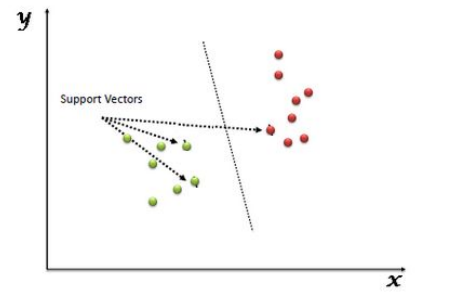

In [ ]:
#Criando o modelo de SVM

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(x_train_tfIdf,y_train)


SVC(gamma='auto', kernel='linear')

In [ ]:
predicted = SVM.predict(x_test_tfIdf)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        47
         2.0       0.00      0.00      0.00        44
         3.0       0.53      0.05      0.10       151
         4.0       0.34      0.06      0.10       389
         5.0       0.71      0.98      0.82      1415

    accuracy                           0.69      2046
   macro avg       0.32      0.22      0.20      2046
weighted avg       0.59      0.69      0.60      2046



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##**RNN**



---


Uma rede neural recorrente (RNN) é uma classe de redes neurais que inclui conexões ponderadas dentro de uma camada (em comparação com as redes de feed-forward tradicionais, onde conecta alimentação apenas para camadas subsequentes). Como as RNNs incluem loops, elas podem armazenar informações ao processar novas entradas. Essa memória os torna ideais para tarefas de processamento onde as entradas anteriores devem ser consideradas (como dados da série temporal). Por esta razão, as redes de deep learning atuais são baseadas em RNNs.

---



In [ ]:

max_len = 80                 #tamanho máximo para 1 entrada
vocab_size = 1000            # tamanho do vocabulário

encoder = OneHotEncoder(sparse=False)
y=np.array(MI['overall'])                   #transformando as "Overalls" com One Hot Encoding
y=encoder.fit_transform(y.reshape(-1,1))

print(y)

x=MI['reviewText']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=7)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [ ]:
#utilizando o Tokenizer para tratar o texto e Tokenizar o texto

tokenizator=tf.keras.preprocessing.text.Tokenizer(
num_words=vocab_size,
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
lower=True,
char_level=False,
oov_token='<OOV>',
)

tokenizator.fit_on_texts(X_train)


In [ ]:

reviews_train = tokenizator.texts_to_sequences(X_train)
x_train = pad_sequences(reviews_train, maxlen=max_len, padding='post', truncating='post')

reviews_test = tokenizator.texts_to_sequences(X_test)
x_test = pad_sequences(reviews_test, maxlen=max_len, padding='post', truncating='post')


x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
#criando o modelo da RNN

RNN = Sequential([
    Embedding(vocab_size+1, 64, input_length=max_len),
    Bidirectional(LSTM(128)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
RNN.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 64)            64064     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 295,237
Trainable params: 295,237
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
RNN_fit = RNN.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
256/256 [==============================] - 49s 171ms/step - loss: 0.9940 - accuracy: 0.6670 - val_loss: 0.9096 - val_accuracy: 0.6916
Epoch 2/10
256/256 [==============================] - 43s 168ms/step - loss: 0.9083 - accuracy: 0.6709 - val_loss: 0.8749 - val_accuracy: 0.6916
Epoch 3/10
256/256 [==============================] - 42s 165ms/step - loss: 0.8575 - accuracy: 0.6720 - val_loss: 0.8868 - val_accuracy: 0.6877
Epoch 4/10
256/256 [==============================] - 43s 167ms/step - loss: 0.8228 - accuracy: 0.6758 - val_loss: 0.8802 - val_accuracy: 0.6901
Epoch 5/10
256/256 [==============================] - 43s 168ms/step - loss: 0.7935 - accuracy: 0.6915 - val_loss: 0.9251 - val_accuracy: 0.6838
Epoch 6/10
256/256 [==============================] - 43s 168ms/step - loss: 0.7682 - accuracy: 0.6966 - val_loss: 0.9309 - val_accuracy: 0.6852
Epoch 7/10
256/256 [==============================] - 48s 187ms/step - loss: 0.7436 - accuracy: 0.6975 - val_loss: 0.9285 - val_ac